In [2]:
from __future__ import print_function
import pandas as pd
from nltk.tokenize import regexp_tokenize
from gensim.models import KeyedVectors
from gensim.models import word2vec
from gensim.scripts import glove2word2vec
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(224)

##########################################
#Importing wiki vector####################
##########################################
## Mac
wiki_en = KeyedVectors.load_word2vec_format('/Users/marcowang/Downloads/text_project/data/word2vec_pretrain_data/wiki-news-300d-1M.vec')

# Ubantu
#wiki_en = KeyedVectors.load_word2vec_format('/home/marco/Downloads/wiki-news-300d-1M.vec')

print('=' * 80)
print('Loading Success ！！')
print('=' * 80)

vocab_wiki = list(wiki_en.vocab.keys())
print(len(vocab_wiki)) ### pretrain vocab)

Loading Success ！！
999994


In [145]:
#loading data
#Mac
news = pd.read_csv('/Users/marcowang/Downloads/APPLE_above10.csv',index_col=0)

In [190]:
news.shape,len(new_token)

((22341, 28), 22338)

In [192]:


#Ubantu
#news = pd.read_csv('/home/marco/Dropbox/Textnews/TextProject/sample_data/news20190406_285.csv',index_col=None)

newsText = [x.split('\\n')[3].replace('<br>-','').replace('<br>','') for x in news['Description']]
flatten = lambda l:[item for sublist in  l for item in sublist]
newsToken = [regexp_tokenize(sent,pattern = '\w+|\$[\d\.]+|\S+') for sent in newsText] #####?
new_token = [x for x in newsToken] ##for clean 
flatToken = flatten(new_token)
allWords = [w.lower() for w in flatToken]
vocabulary = list(set(allWords))  # news vocabulary 
print(len(vocabulary))

164683


In [200]:
newsText[0]

'      A.L.E.X. is a fun puzzle game and a great way to train your brain. A.L.E.X. helps you think and plan logically as you program your robot A.L.E.X. with a sequence of commands to get through each level from start to finish. I named A.L.E.X. after my nephew, and created a game I would want him to play. The lower levels of the games are suitable for children as young as six and the game is enjoyable for adults too! FREE VERSION Includes 25 levels Includes feature to create your own puzzle UPGRADE 35 additional levels More block types to create your own puzzles 3 additional looks for A.L.E.X.'

In [201]:
#news['Description'][9].split('\\n')[3]

In [202]:
#word 2 index in corpus
word2index={'<PAD>': 0, '<UNK>': 1} # pad means padding !

for vo in vocabulary:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

In [203]:
y_rate = list(news['Rating'])
# negative impact label as '2'
def binaryData(y,label):
    ys = y[:]
    for i in range(len(ys)):
        if ys[i] == label:
            ys[i] = np.array(1)
        else:
            ys[i] = np.array(0)
    return list(ys)

In [204]:
y_4 = binaryData(y_rate,label = 4)
y_9 = binaryData(y_rate,label = 9)
y_12 = binaryData(y_rate,label = 12)
y_17 = binaryData(y_rate,label = 17)

In [205]:
# For GPU use
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

# Batch
def getBatch(batch_size, train_data):
        random.shuffle(train_data)
        sindex = 0
        eindex = batch_size
        while eindex < len(train_data):
            batch = train_data[sindex: eindex]
            temp = eindex
            eindex = eindex + batch_size
            sindex = temp
            yield batch

        if eindex >= len(train_data):
            batch = train_data[sindex:]
            yield batch




#seq text transform
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

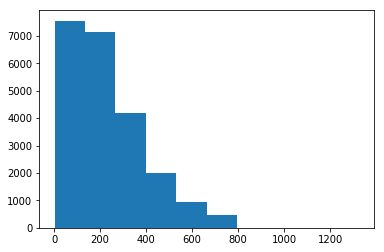

1325

In [206]:
xxx= [len(x) for x in new_token]
import matplotlib.pyplot as plt
plt.hist(xxx)
plt.show()
max(xxx)

In [208]:
def pad_to_batch(batch,max_x = 955):
    x,y = zip(*batch)
    
    x_p = []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([word2index['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
    return torch.cat(x_p), torch.cat(y).type(LongTensor).view(-1)

In [209]:
#pretrain vector
pretrained = []

for key in word2index.keys():
    try:
        pretrained.append(wiki_en[word2index[key]])
    except:
        pretrained.append(np.random.randn(300))
        
pretrained_vectors = np.vstack(pretrained)

In [210]:
# 4
X_p, y_p = [],[]

for x,y in zip(newsToken,y_4):
    if len(x) <=1000:
        #print(y)
        X_p.append(prepare_sequence(x, word2index).view(1, -1))
        #print(Variable(LongTensor(y).view(1, -1)))
        y_p.append(Variable(torch.from_numpy(y).view(1, -1)))
        
    
data_p = list(zip(X_p,y_p))
random.shuffle(data_p)

train_data = data_p[: int(len(data_p) * 0.8)]
test_data = data_p[int(len(data_p) * 0.2):]
X_p[0]

tensor([[     1,      1,   2906,    878,  72032, 146178,  81086,  64699,    878,
         148599, 109143, 102274, 121835,  28322,  59804, 142610,      1,      1,
         100551,    656,  20799,  64699,  10454,  58337, 117301,    656,  58959,
          28322,  62290,      1,      1, 138873,    878, 140406,  25106, 132972,
         102274,  36741,  38238,  34045, 114918,  74721,  30662, 102274, 114152,
         142610,      1, 144044,      1,      1, 103788,  84738,  53654, 134739,
          64699,  19021,    878,  81086,      1,  88368,   3880, 144177, 102274,
          67464, 142610,      1,  94740, 111241,  25106,  93006,  62679,   4999,
         136594,  41810, 148928, 117301, 111612, 117301,  93857,  64699,  93006,
          81086,   2906,  53512,  41810, 138175,  65058,  96880,      1,      1,
              1,  44431, 111241,      1,  82448, 102274,  17133,  28322,  22276,
         146178,      1, 159526,  45616, 111241,      1,  23014,  30229, 102274,
          17133,  28322,  22

In [211]:
train_data[4][1],type(train_data[4][1])

(tensor([[1]]), torch.Tensor)

In [212]:
##Model Structure 
class Rate(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(Rate,self).__init__()
        self.embedding_w = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(     # 
        input_size = 300,      # vecter dimension
        hidden_size=64,     # rnn hidden unit
        num_layers=1,       # 
        batch_first=True,   # input & output 
        )
        self.out = nn.Linear(64, 2) #  1 class
        
    
    
    def init_weights(self, pretrained_word_vectors, is_static=True):
        self.embedding_w.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding_w.weight.requires_grad = False


    def forward(self, inputs, is_training=False):
        inputs = self.embedding_w(inputs) # 
        r_out, (h_n, h_c) = self.rnn(inputs, None)
        out = self.out(r_out[:, -1, :])
        return out

In [ ]:
#4
EPOCH = 10
BATCH_SIZE = 500
LR = 0.001
TIME_STEP = 191          # rnn time step / 
INPUT_SIZE = 5

apmodel = Rate(len(word2index), 300)
apmodel.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(apmodel.parameters(), lr=LR)

for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        print(i)
        inputs,targets = pad_to_batch(batch)
        #print(targets.size())          
        apmodel.zero_grad()
        preds = apmodel(inputs,True)
        #print(preds.size())
        loss = loss_function(preds, targets)
        losses.append(loss.data.mean())
        loss.backward()
        
        
        optimizer.step()
        acc = 0
        if i % 100 == 0:
            for test in test_data:
                oup = apmodel(test[0])
                a = (torch.max(oup,1)[1].item())
                b = (test[1][0][0].item())
                if a == b:
                    acc +=1
            accuracy = acc/len(test_data)
            print('Epoch: ', str(epoch)+'/'+str(EPOCH), '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


0
Epoch:  0/10 | train loss: 0.7260 | test accuracy: 0.39
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
Epoch:  1/10 | train loss: 0.6342 | test accuracy: 0.39
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
Epoch:  2/10 | train loss: 0.6013 | test accuracy: 0.39
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
Epoch:  3/10 | train loss: 0.6114 | test accuracy: 0.39
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
Epoch:  4/10 | train loss: 0.6494 | test accuracy: 0.39
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [119]:
n_data = torch.ones(100, 2)         # 数据的基本形态
x0 = torch.normal(2*n_data, 1)      # 类型0 x data (tensor), shape=(100, 2)
y0 = torch.zeros(100)               # 类型0 y data (tensor), shape=(100, )
x1 = torch.normal(-2*n_data, 1)     # 类型1 x data (tensor), shape=(100, 1)
y1 = torch.ones(100)     

In [128]:
# 注意 x, y 数据的数据形式是一定要像下面一样 (torch.cat 是在合并数据)
x = torch.cat((x0, x1), 0).type(torch.FloatTensor)  # FloatTensor = 32-bit floating
y = torch.cat((y0, y1), ).type(torch.LongTensor)    # LongTensor = 64-bit integer

# plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1], c=y.data.numpy(), s=100, lw=0, cmap='RdYlGn')
# plt.show()

In [ ]:
# 4
X_p12, y_p12 = [],[]

for x,y in zip(newsToken,y_12):
    if len(x) <=1000:
        #print(y)
        X_p12.append(prepare_sequence(x, word2index).view(1, -1))
        #print(Variable(LongTensor(y).view(1, -1)))
        y_p12.append(Variable(torch.from_numpy(y).view(1, -1)))
        
    
data_p12 = list(zip(X_p,y_p))
random.shuffle(data_p12)

train_data12 = data_p[: int(len(data_p12) * 0.8)]
test_data12 = data_p[int(len(data_p12) * 0.2):]
X_p12[0]

In [ ]:
#4
EPOCH = 10
BATCH_SIZE = 500
LR = 0.001
TIME_STEP = 191          # rnn time step / 
INPUT_SIZE = 5

apmodel12 = Rate(len(word2index), 300)
apmodel12.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(apmodel12.parameters(), lr=LR)

for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_data12)):
        print(i)
        inputs,targets = pad_to_batch(batch)
        #print(targets.size())          
        apmodel12.zero_grad()
        preds = apmodel12(inputs,True)
        #print(preds.size())
        loss = loss_function(preds, targets)
        losses.append(loss.data.mean())
        loss.backward()
        
        
        optimizer.step()
        acc = 0
        if i % 100 == 0:
            for test in test_data12:
                oup = apmodel12(test[0])
                a = (torch.max(oup,1)[1].item())
                b = (test[1][0][0].item())
                if a == b:
                    acc +=1
            accuracy = acc/len(test_data12)
            print('Epoch: ', str(epoch)+'/'+str(EPOCH), '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
